# About

This script generates the numerical plots for an N-dim Kuramoto system with a constant, non-adaptive delay (dirac distribution), with repeated trials under a fixed history function. The purpose is to test the stability criterion $\cos(\Omega \tau^0) > 0$, where $\Omega$ is the global frequency satisfying $\Omega = \omega_0 + g \sin(-\Omega \tau^0)$.

All trials are performed in MATLAB. The MATLAB script is found in 'sec3_dirac_numerics.mat'

From folder, import the 'parameters.mat' file. Here, 'g', 'tau0' are arrays that index the solution files in the form '{index_g}_{index_tau0}.mat'.

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files from Matlab
import_folder = 'sec3_dirac_numerics2' # 'sec3_dirac_numerics2'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'matlab', 'data', import_folder)

filenames = os.listdir(dir_im)
filenames.remove('parameters.mat')

# Import and compile data

## Parameters

In [3]:
dir_par = os.path.join(dir_im, 'parameters.mat')
dict_par = sio.loadmat(dir_par)

g_arr = np.reshape(dict_par['g'], -1)
tau0_arr = np.reshape(dict_par['tau0'], -1)

w0 = dict_par['omega0'][0,0]
t0 = dict_par['t0'][0,0]
tf = dict_par['tf'][0,0]
Omega0 = dict_par['Omega0'][0,0]
std = dict_par['std'][0,0]
N = dict_par['N'][0,0]

# Asymptotic percentage
asy = 0.1

## Import data

In [4]:
# Compile arrays
tau0_mesh, g_mesh = np.meshgrid(tau0_arr, g_arr)
order_mesh = np.zeros(g_mesh.shape)
Omega_mesh = np.zeros(g_mesh.shape)

# Which trials to plot (ind_g, ind_tau0)
ind_plot1 = (10, 16)
ind_plot2 = (2, 10)

# Acquire trials data
for i in range(len(filenames)):
    
    # Import .mat file
    filename = filenames[i]
    dir_mat = os.path.join(dir_im, filename)
    dict_mat =  sio.loadmat(dir_mat)
    
    # Get g, tau0 indices
    inds_file = filename.split('.')[0]
    ind_g, ind_tau0 = inds_file.split('_')
    ind_g = int(ind_g)
    ind_tau0 = int(ind_tau0)
    
    # Compile solution dictionary
    sol = {'t': np.reshape(dict_mat['t'], -1),
           'y': dict_mat['y'],
           'yp': dict_mat['yp']
          }
    
    # Compute the global frequency:
    arrOmega = asylib.weight_avg(sol['t'], sol['yp'], asy)
    asyOmega = np.sum(arrOmega) / arrOmega.size
    
    # Get array of phases
    arrLinear = asyOmega*sol['t']
    arrLinear = arrLinear[:,None]

    arrPhases = sol['y'] - arrLinear
    sol['phases'] = arrPhases
    
    # Order parameter
    orderY = funlib.order(sol['y'])
    sol['order'] = orderY.copy()
    orderY = orderY.reshape(-1,1)
    asyOrder = np.sum(asylib.weight_avg(sol['t'], orderY, asy))
    
    # Store
    Omega_mesh[ind_g, ind_tau0] = asyOmega
    order_mesh[ind_g, ind_tau0] = asyOrder
    
    # Store solutions
    if ind_g == ind_plot1[0] and ind_tau0 == ind_plot1[1]:
        sol1 = sol.copy()
        sol1['g'] = dict_mat['g'][0,0]
        sol1['tau0'] = dict_mat['tau0'][0,0]
        sol1['order'] = orderY
        sol1['phases'] = arrPhases
        sol1['asyOmega'] = asyOmega
        
    elif ind_g == ind_plot2[0] and ind_tau0 == ind_plot2[1]:
        sol2 = sol.copy()
        sol2['g'] = dict_mat['g'][0,0]
        sol2['tau0'] = dict_mat['tau0'][0,0]
        sol2['order'] = orderY
        sol2['phases'] = arrPhases
        sol2['asyOmega'] = asyOmega

# Bound order_mesh between 0 and 1
order_mesh = np.maximum(order_mesh, np.zeros(order_mesh.shape))
order_mesh = np.minimum(order_mesh, np.ones(order_mesh.shape))

# Plot figure 1

## Options

In [5]:
# Plot positions [left, bottom, width, height]
bbox0 = [0.05, 0.65, 0.20, 0.35] # Top left (trial 1 freqs)
bbox1 = [0.05, 0.10, 0.20, 0.35] # Bottom left (trial 1 phases)
bbox2 = [0.30, 0.65, 0.20, 0.35] # Top right (trial 2 freqs)
bbox3 = [0.30, 0.10, 0.20, 0.35] # Bottom right (trial 2 phases)
bbox4 = [0.62, 0.10, 0.38, 0.90] # Right (order)

# Colours
cmap1 = plt.get_cmap('spring')
cmap2 = plt.get_cmap('cool')

num1 = sol1['yp'].shape[1]
num2 = sol2['yp'].shape[1]

colors1 = [cmap1(i) for i in np.linspace(0, 0.99, num1)]
colors2 = [cmap2(i) for i in np.linspace(0, 0.99, num2)]

col1 = 'orange'
col2 = 'blue'
col_w0 = 'green'

# Alphas
alpha1 = 0.8
alpha_w0 = 0.8

# Linewidths
lw1 = 0.5

## Generate figure

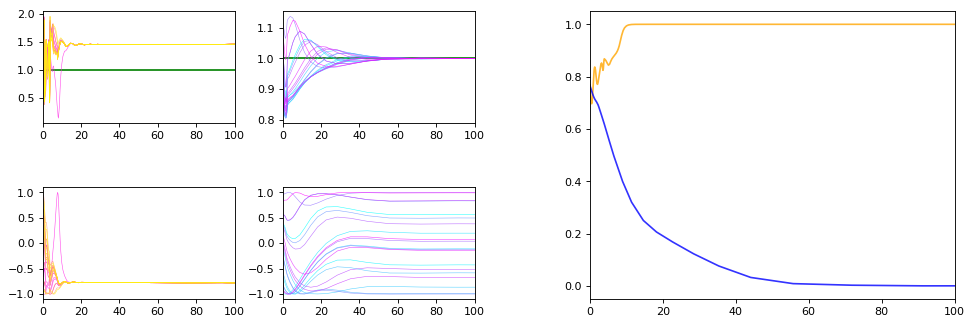

In [6]:
fig, ax = plt.subplots(5, figsize=(12,4), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)
ax[4].set_position(bbox4)


# Plot trial 1:
ax[0].set_prop_cycle(color=colors1)
ax[1].set_prop_cycle(color=colors1)
ax[0].plot(sol1['t'], sol1['yp'], alpha=alpha1, linewidth=lw1, zorder=2)
ax[1].plot(sol1['t'], np.sin(sol1['phases']), alpha=alpha1, linewidth=lw1, zorder=2)

# Plot trial 2:
ax[2].set_prop_cycle(color=colors2)
ax[3].set_prop_cycle(color=colors2)
ax[2].plot(sol2['t'], sol2['yp'], alpha=alpha1, linewidth=lw1, zorder=2)
ax[3].plot(sol2['t'], np.sin(sol2['phases']), alpha=alpha1, linewidth=lw1, zorder=2)

# Orders
ax[4].plot(sol1['t'], sol1['order'], color=col1, alpha=alpha1, zorder=2)
ax[4].plot(sol2['t'], sol2['order'], color=col2, alpha=alpha1, zorder=2)

# Adjust axes
for i in range(len(ax)):
    ax[i].set_xlim(left=t0, right=tf/2)

# Axis lines
ax[0].axhline(y=w0, color=col_w0, zorder=0)
ax[2].axhline(y=w0, color=col_w0, zorder=0)

# Maybe showcase three behaviours (stable, neutrally stable, unstable)

## Statistics

In [7]:
g1 = sol1['g']
tau0_1 = sol1['tau0']
g2 = sol2['g']
tau0_2 = sol2['tau0']
asyOmega1 = sol1['asyOmega']
asyOmega2 = sol2['asyOmega']
print(f'Trial 1: \n g = {g1}, tau0 = {tau0_1}, Omega = {asyOmega1}')
print(f'Trial 2: \n g = {g2}, tau0 = {tau0_2}, Omega = {asyOmega2}')

Trial 1: 
 g = 1, tau0 = 4, Omega = 1.4533761804266714
Trial 2: 
 g = 0.2, tau0 = 2.5, Omega = 0.9999972922336232


# Plot figure 2 

## Boundary curves

The boundary curve for $\tau^0$, $g$ using the stability criterion $\cos(\Omega\tau^0) = 0$. This is the strict stability region. Note that semi-stability can exist outside of this region.

In [8]:
# Arrays
tau0_boundarr = np.array([])
g_boundarr = np.array([])

k_list = np.arange(0, 4, 1)
num_steps = 500

for k in k_list:
    L_k = (4*k + 1)*pi / 2
    M_k = (2*k+1)*pi
    U_k = (4*k + 3)*pi / 2
    tau0_arrk1 = np.linspace(L_k, M_k, num=num_steps) / w0
    tau0_arrk2 = np.linspace(M_k, U_k, num=num_steps) / w0
    
    g_arrk1 = w0 - L_k / tau0_arrk1
    g_arrk2 = U_k / tau0_arrk2 - w0
    
    tau0_boundarr = np.concatenate((tau0_boundarr, tau0_arrk1, tau0_arrk2))
    g_boundarr = np.concatenate((g_boundarr, g_arrk1, g_arrk2))

## Options

In [9]:
# Plot positions [left, bottom, width, height]
bbox0 = [0.05, 0.1, 0.35, 0.9] # Left (Asy. Omega heat map)
bbox1 = [0.42, 0.1, 0.03, 0.9] # Right (Asy. Omega colour legend)
bbox2 = [0.60, 0.1, 0.35, 0.9] # Right (Asy. order heat map)
bbox3 = [0.97, 0.1, 0.03, 0.9] # Right (Asy. order colour legend)

# Cmaps
cmap1 = 'PRGn'
cmap2 = 'Blues'

# Curve colors
col1 = 'red'
col2 = 'yellow'

# Levels
num_levels1 = 21
num_levels2 = 21

levels1 = np.linspace(0, np.max(Omega_mesh), num_levels1, endpoint=True)
levels2 = np.linspace(0, 1, num_levels2, endpoint=True)

mapstep1 = 0.25
mapstep2 = 0.1

## Generate figure

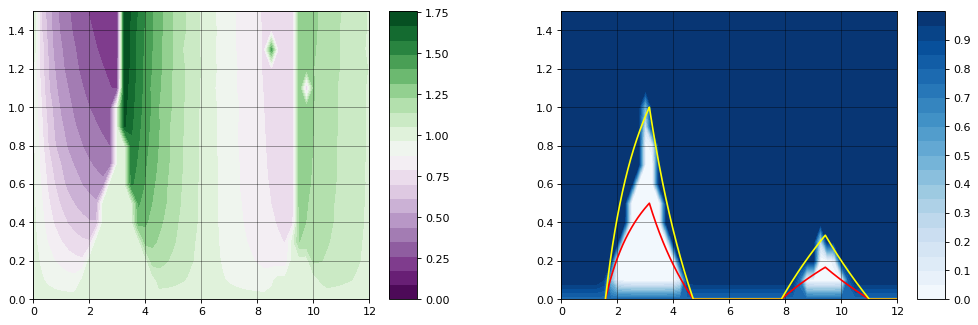

In [10]:
fig, ax = plt.subplots(4, figsize=(12,4), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)

# Plot colormap
cs1 = ax[0].contourf(tau0_mesh, g_mesh, Omega_mesh, levels1, cmap=cmap1)
cs2 = ax[2].contourf(tau0_mesh, g_mesh, order_mesh, levels2, cmap=cmap2)

ax[0].grid(b=True, which='both', color='black', alpha=0.4, zorder=-1)
ax[2].grid(b=True, which='both', color='black', alpha=0.4, zorder=-1)

ax[2].plot(tau0_boundarr, g_boundarr, color=col1, zorder=2)
ax[2].plot(tau0_boundarr, 2*g_boundarr, color=col2, zorder=2)

ax[2].set_xlim(left=np.min(tau0_mesh), right=np.max(tau0_mesh))
ax[2].set_ylim(bottom=np.min(g_mesh), top=np.max(g_mesh))

# Colour legends
fig.colorbar(cs1, cax=ax[1], ticks=np.arange(0, np.max(levels1), mapstep1))
fig.colorbar(cs2, cax=ax[3], ticks=np.arange(0, 1, mapstep2))

In [11]:
Omega_mesh[0,0]

1.0